In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.stats import zscore
import os
import pandas as pd
import icecream as ic
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

from experimentsetup import *
from plotty import *
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

main_dir = "mrt/"
stationnames = np.loadtxt(main_dir+"station_name_en.txt",dtype=str,delimiter='/n',encoding='utf-8-sig')
subsetstationnames = ["Fu Jen University", "Zhongshan Junior High School",
                      "Zhongshan Elementary School", "Sanmin Senior High School",
                      "St. Ignatius High School", "Sanhe Junior High School", 
                      "Sanchong Elementary School", # schools
                      "Wanfang Hospital", "National Taiwan University Hospital", "Far Eastern Hospital", # from hospitals
                      "Longshan Temple", "Shandao Temple", "Xianse Temple", "Xingtian Temple"] # from temples
stations_enter = [station+" enter" for station in stationnames] 
stations_exit = [station+" exit" for station in stationnames] 
columns_all = np.concatenate((np.array(['yyyymm','day','hour']),np.array(stations_enter),np.array(stations_exit)))

In [2]:
def loadtaipeidata(main_dir, stationnames):
    pd.set_option('display.max_rows', None)
    stations_enter = [station+" enter" for station in stationnames] 
    stations_exit = [station+" exit" for station in stationnames] 
    columns_all = np.concatenate((np.array(['yyyymm','day','hour']),np.array(stations_enter),np.array(stations_exit)))
    d = loadmat(main_dir+"all_data.mat")
    d = d['data']
    d = d.transpose()
    allstationdata = pd.DataFrame(d,columns_all) # load all station data into dataframe
    return allstationdata.T

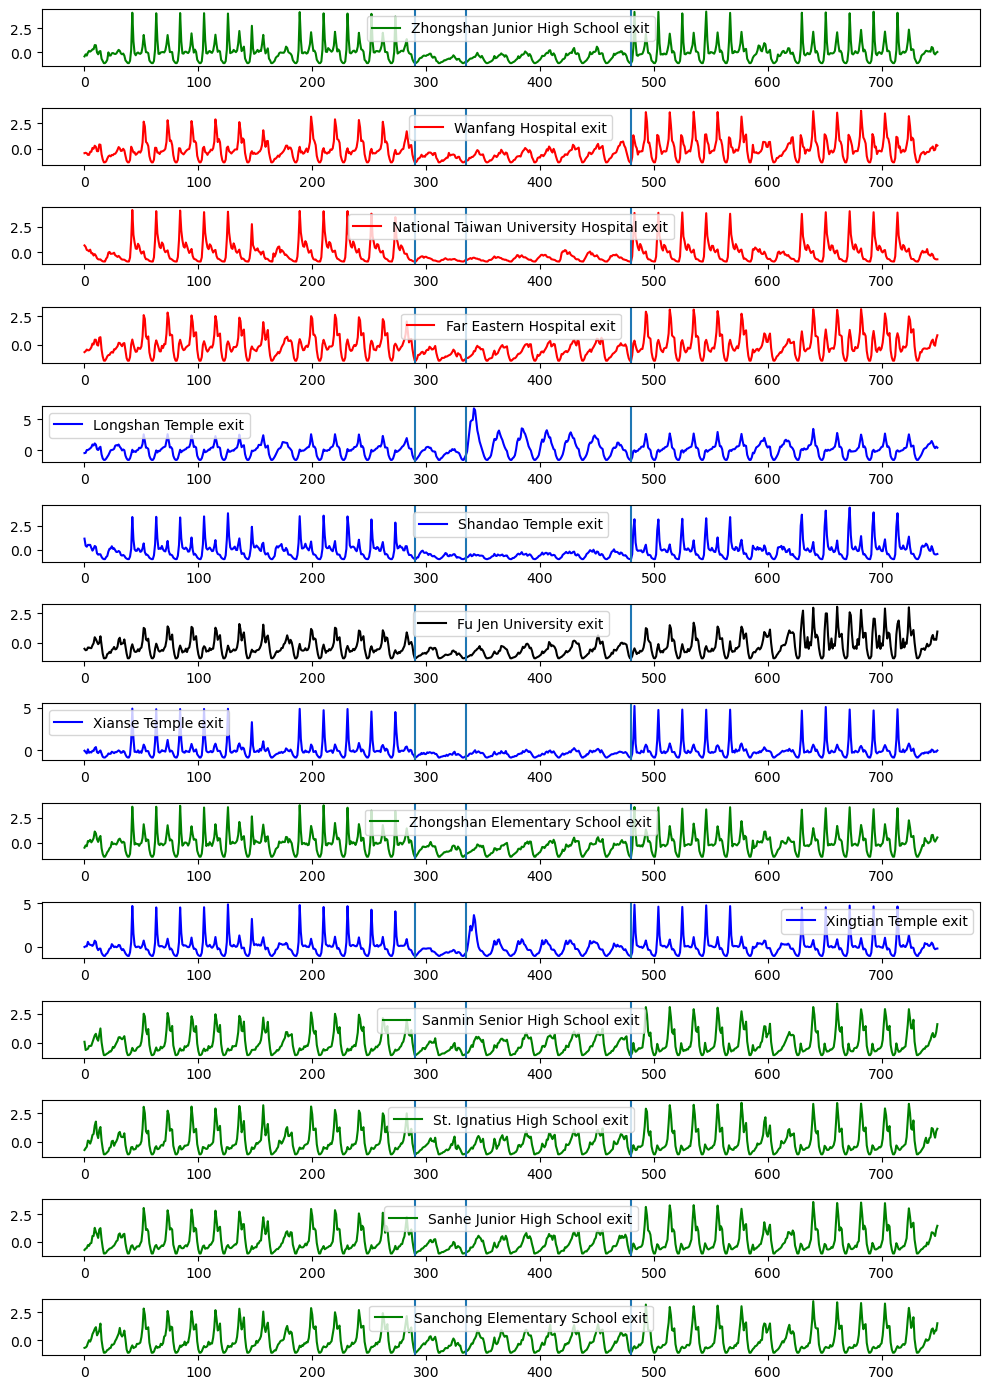

yyyymm    201601
day           23
hour           8
Name: 1750, dtype: int32 yyyymm    201602
day           27
hour          23
Name: 2500, dtype: int32
yyyymm    201602
day            5
hour           1
Name: 2040, dtype: int32
yyyymm    201602
day           15
hour           5
Name: 2230, dtype: int32
yyyymm    201602
day            8
hour           7
Name: 2085, dtype: int32


In [4]:
allstationdata = loadtaipeidata(main_dir,stationnames)
fig, axs = plt.subplots(14,1,figsize=(10,14))
g = 0
timespan = allstationdata[['yyyymm','day','hour']]
ID1, ID2 = 290, 480
ID3 = 335
for c in columns_all:
    if " exit" in c:
        if c[:-5] in subsetstationnames:
            ts = np.asarray(zscore(allstationdata[c],nan_policy='omit'))
            color = "k"
            if "Hospital" in c:
                color = "r"
            elif "School" in c:
                color = "g"
            elif "Temple" in c:
                color = "b"
            axs[g].plot(ts[1750:2500],label=c,c=color)
            axs[g].axvline(x=ID1)
            axs[g].axvline(x=ID2)
            axs[g].axvline(x=ID3)
            axs[g].legend()
            axs[g].legend()
            g += 1
        if g > 13:
            break
# plt.savefig('<save location>',fmt='svg')
plt.show()
print(timespan.iloc[1750],timespan.iloc[2500])
print(timespan.iloc[1750+ID1])
print(timespan.iloc[1750+ID2])
print(timespan.iloc[1750+ID3])

## Handcrafted dictionaires

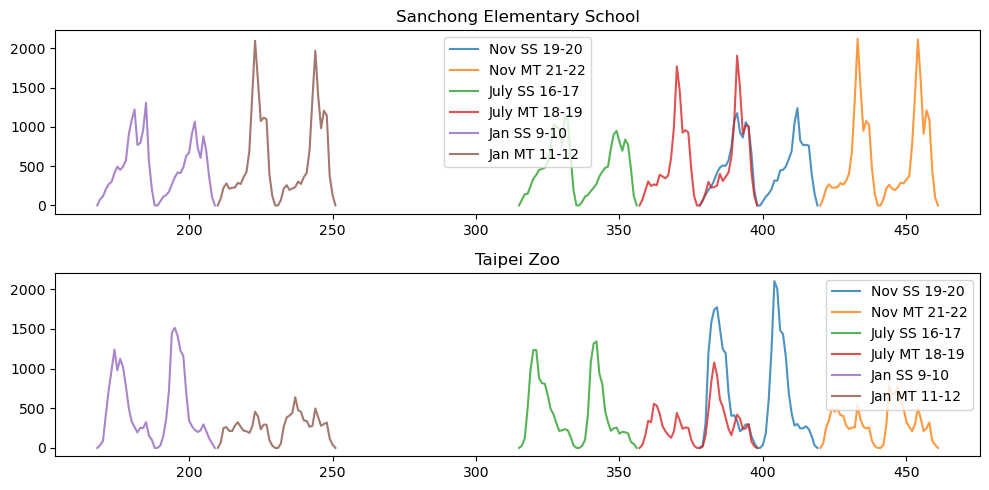

In [6]:
# Random day, not obvious holiday
patternmonths = ['201601_exit.mat','201603_exit.mat','201607_exit.mat', '201611_exit.mat']
columns = np.concatenate((np.array(['day','hour']),stations_exit))
exemplar = {}
for (root,dirs,files) in os.walk(main_dir):
    for f in files:
        if f in patternmonths:
            data = loadmat(main_dir+"/"+f)
            data = data['data']
            data = data.transpose()
            data = pd.DataFrame(data,columns)
            data = data.transpose()
            if f == "201606_exit.mat":
                exemplar['Mar RF 10-11'] = pd.concat([data[data['day']==10],data[data['day']==11]])
                exemplar['Mar SS 12-13'] = pd.concat([data[data['day']==12],data[data['day']==13]])
            elif f == "201607_exit.mat": 
                exemplar['July SS 16-17'] = pd.concat([data[data['day']==16],data[data['day']==17]])
                exemplar['July MT 18-19'] = pd.concat([data[data['day']==18],data[data['day']==19]])
            elif f == "201601_exit.mat": 
                exemplar['Jan SS 9-10'] = pd.concat([data[data['day']==9],data[data['day']==10]])
                exemplar['Jan MT 11-12'] = pd.concat([data[data['day']==11],data[data['day']==12]])
            elif f == "201611_exit.mat":
                exemplar["Nov SS 19-20"] = pd.concat([data[data['day']==19],data[data['day']==20]])
                exemplar["Nov MT 21-22"] = pd.concat([data[data['day']==21],data[data['day']==22]])

fig, axs = plt.subplots(2,1,figsize=(10,5))
for i in exemplar.keys():
    tmp = exemplar[i]
    axs[0].plot(tmp['Sanchong Elementary School exit'], label=i, alpha=0.8)
    axs[1].plot(tmp['Taipei Zoo exit'], label=i, alpha=0.8)
    axs[0].set_title('Sanchong Elementary School')
    axs[1].set_title('Taipei Zoo')
    axs[0].grid()
    axs[0].legend()
    axs[1].grid()
    axs[1].legend()
plt.show()

use_dicts = [[] for i in range(len(subsetstationnames))]
label_colors = {station:'k' for station in subsetstationnames}
for pattern in exemplar.keys():
    day = exemplar[pattern]
    for station in range(len(subsetstationnames)):
        k = subsetstationnames[station] + " exit"
        use_dicts[station].append(zscore(np.array(day[k]),nan_policy='omit'))
use_dicts = np.asarray(use_dicts)

Make Distmat: 100%|██████████| 14/14 [00:02<00:00,  5.25it/s]


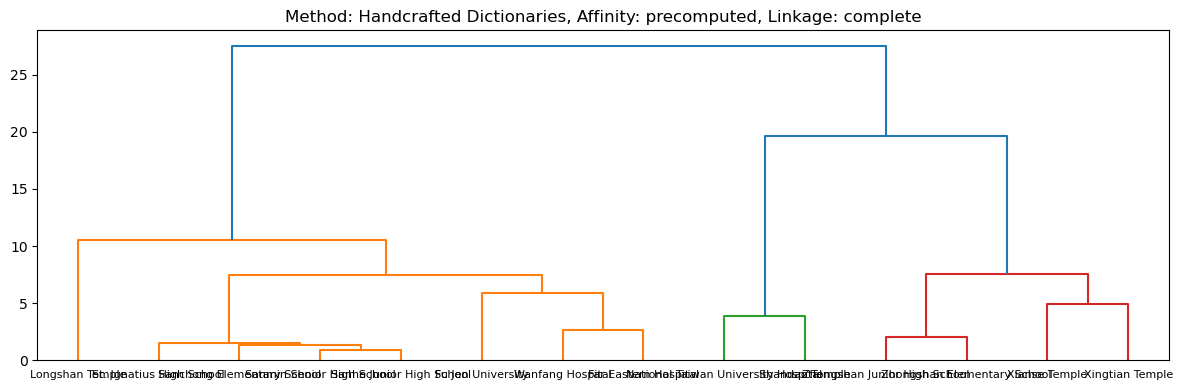

In [7]:
# make distmat for handcrafted
e = Experiment("PRECIS", [8,42], algyield=True, multivariate=False, downsamplefactor=1)
distmat = e.distmat_from_dicts(use_dicts)
# for this particular dataset, using a different plotting function will improve quality of life; the function was written for other datasets whose labels were not automatically rotated
plotty_ac(None, "Handcrafted Dictionaries", "precomputed", "complete", distmat, subsetstationnames, label_colors)

## Yeh Dictionaries

In [8]:
pd.set_option('display.max_rows', None)
stations_enter = [station+" enter" for station in stationnames] 
stations_exit = [station+" exit" for station in stationnames] 
columns_all = np.concatenate((np.array(['yyyymm','day','hour']),np.array(stations_enter),np.array(stations_exit)))
allstationdata = loadtaipeidata(main_dir,stationnames)
yeh_usedicts = []
ex = Experiment("PRECIS", [8,42], algyield=True, multivariate=False, downsamplefactor=1)
empty_dicts = 0
for c in columns_all:
    if " exit" in c:
        if c[:-5] in subsetstationnames:
            ts = np.asarray(zscore(allstationdata[c],nan_policy='omit'))
            # due to some initial problems in variable types, a small (negligible) bit of randomn signal was added to ts to produce the figure currently in use for the paper; you will see that not using it produces the clustering below, which is semantically equivalent to that in the paper (all the main clusters are the same)
            _, idxs = ex.make_exemplar(ts)
            d = []
            for s,e in idxs:
                d.append(ts[s:e])
            if len(d) < 1: 
                empty_dicts += 1 # useful when exploring a dataset, not applicable here
                break
            yeh_usedicts.append(d)
print("Empty dicts: {}".format(empty_dicts))
yeh_distmat = ex.distmat_from_dicts(yeh_usedicts)

Make Distmat:   0%|          | 0/14 [00:00<?, ?it/s]

Empty dicts: 0


Make Distmat: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


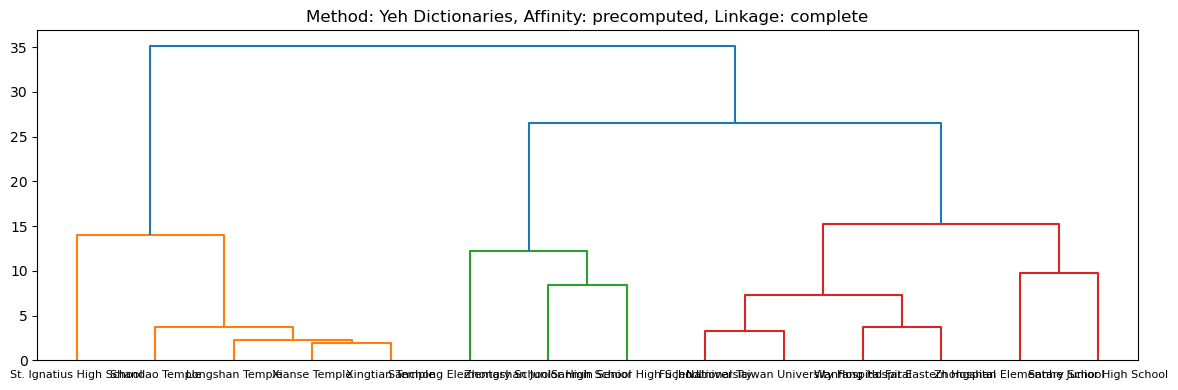

In [42]:
label_colors = {station:'k' for station in subsetstationnames}
plotty_ac(None, "Yeh Dictionaries", "precomputed", "complete", yeh_distmat, subsetstationnames, label_colors)

### k-Shape

In [4]:
from kshape.core import kshape
from scipy.stats import zscore
import time

clusterts = []
numts = 0
label_colors = {station:'k' for station in subsetstationnames}
for c in columns_all:
    if " exit" in c:
        if c[:-5] in subsetstationnames:
            ts = np.asarray(zscore(allstationdata[c],nan_policy='omit'))
            bad = np.where(np.isnan(ts))
            ts[bad] = np.nanmean(ts)
            clusterts.append(ts)
            numts += 1

STARTTIME = time.time()
clusters = kshape(clusterts, 3)
ENDTIME = time.time()
print("kShape Time Elapsed: {}".format(ENDTIME-STARTTIME))

kShape Time Elapsed: 974.6336660385132


In [5]:
c = [i[1] for i in clusters] # index 0 are the values
for j in c: # print clusters
    print(np.asarray(subsetstationnames)[j])

['Sanchong Elementary School']
['Zhongshan Junior High School' 'Sanmin Senior High School'
 'St. Ignatius High School' 'Longshan Temple' 'Shandao Temple'
 'Xianse Temple' 'Xingtian Temple']
['Fu Jen University' 'Zhongshan Elementary School'
 'Sanhe Junior High School' 'Wanfang Hospital'
 'National Taiwan University Hospital' 'Far Eastern Hospital']


In [ ]:
# kshape output
# kShape Time Elapsed: 974.6336660385132
# ['Sanchong Elementary School']
# ['Zhongshan Junior High School' 'Sanmin Senior High School'
#  'St. Ignatius High School' 'Longshan Temple' 'Shandao Temple'
#  'Xianse Temple' 'Xingtian Temple']
# ['Fu Jen University' 'Zhongshan Elementary School'
#  'Sanhe Junior High School' 'Wanfang Hospital'
#  'National Taiwan University Hospital' 'Far Eastern Hospital']

# Catch 22

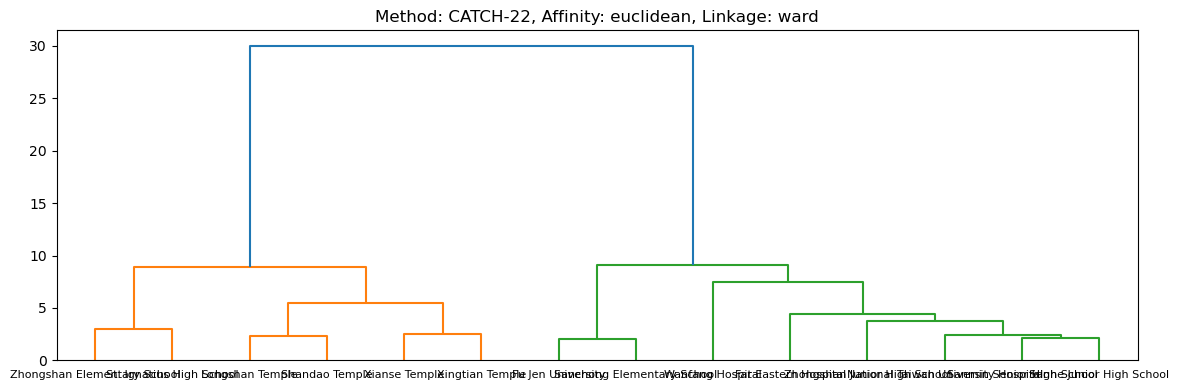

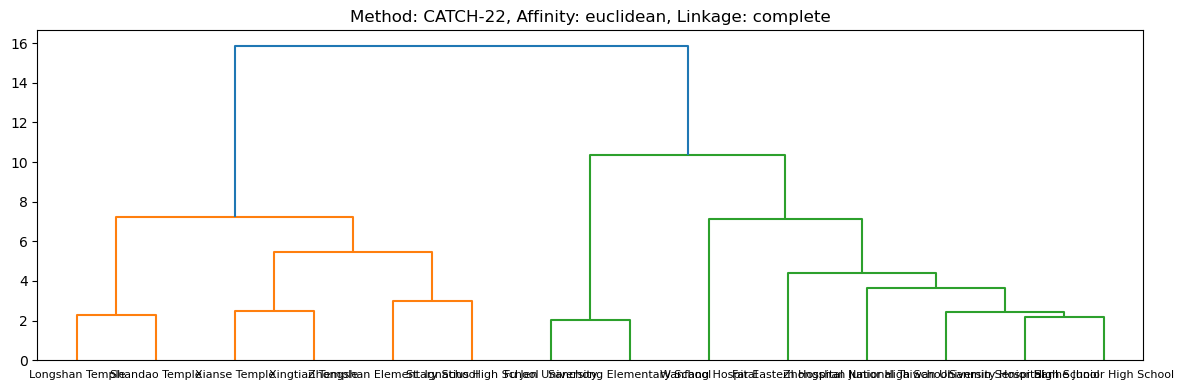

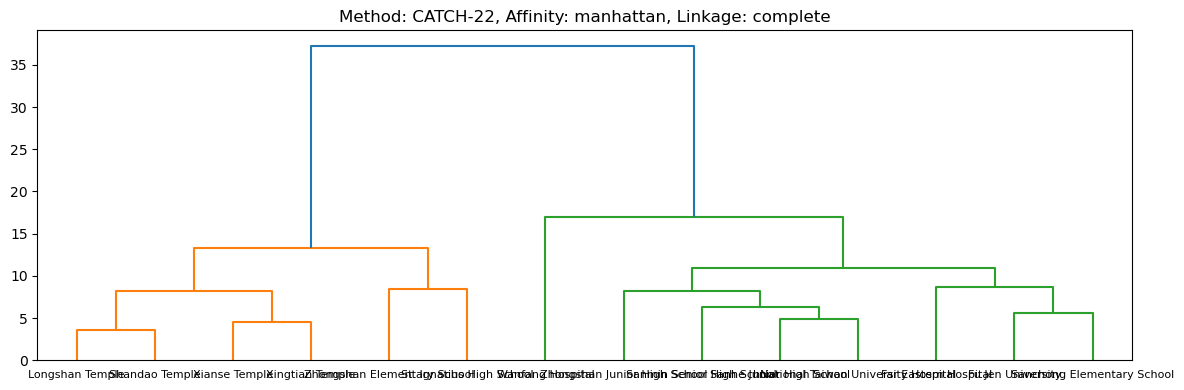

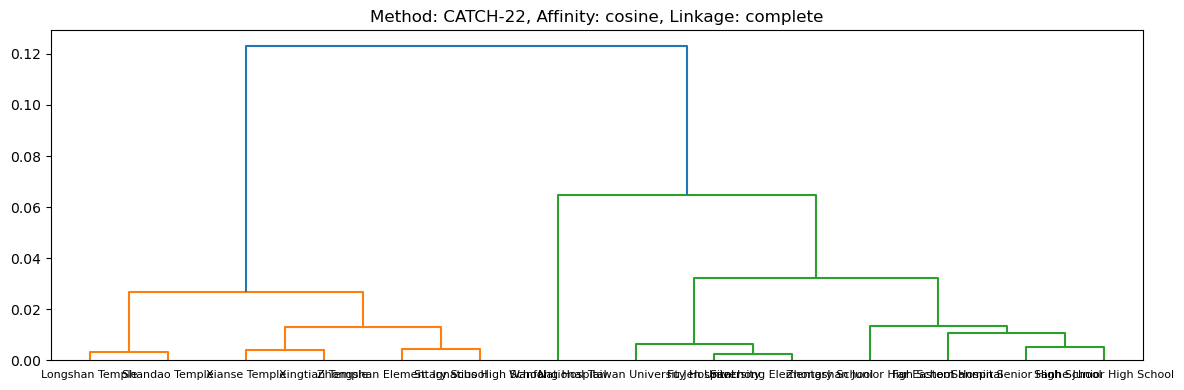

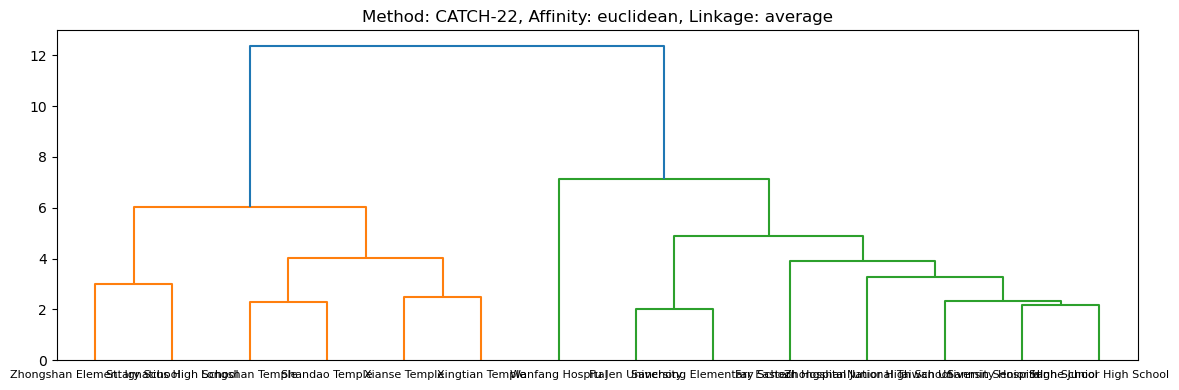

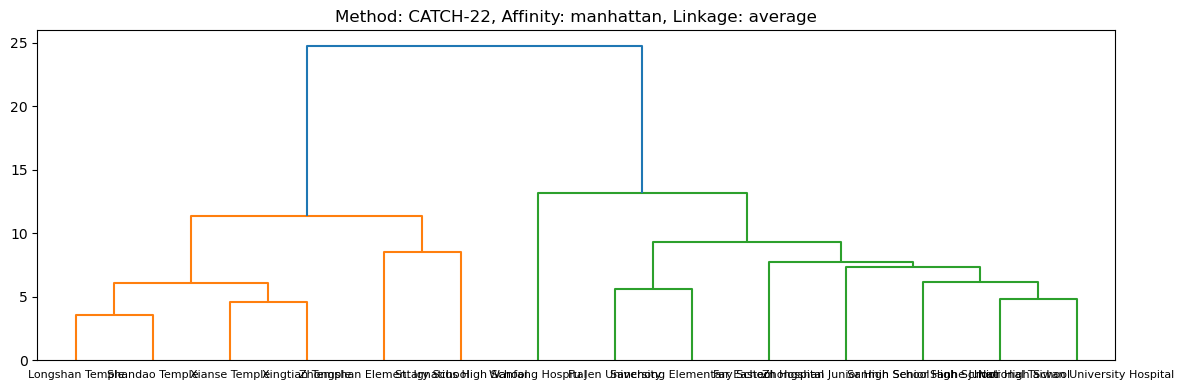

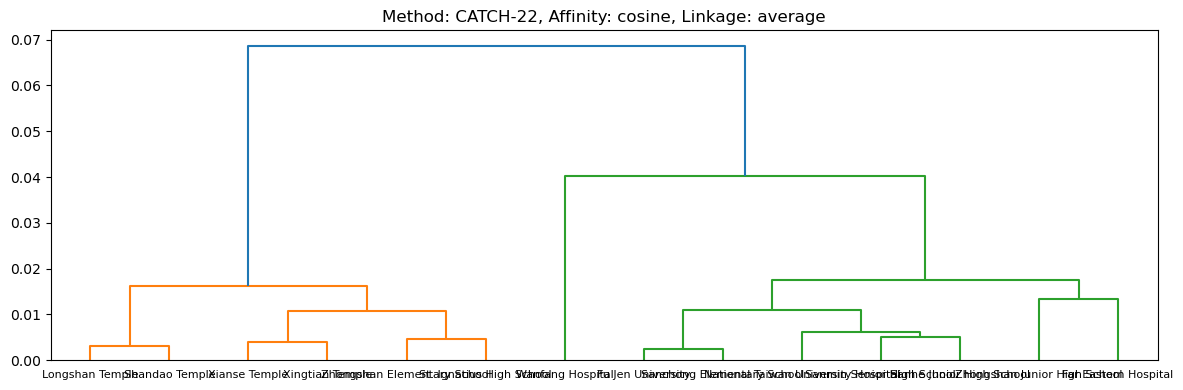

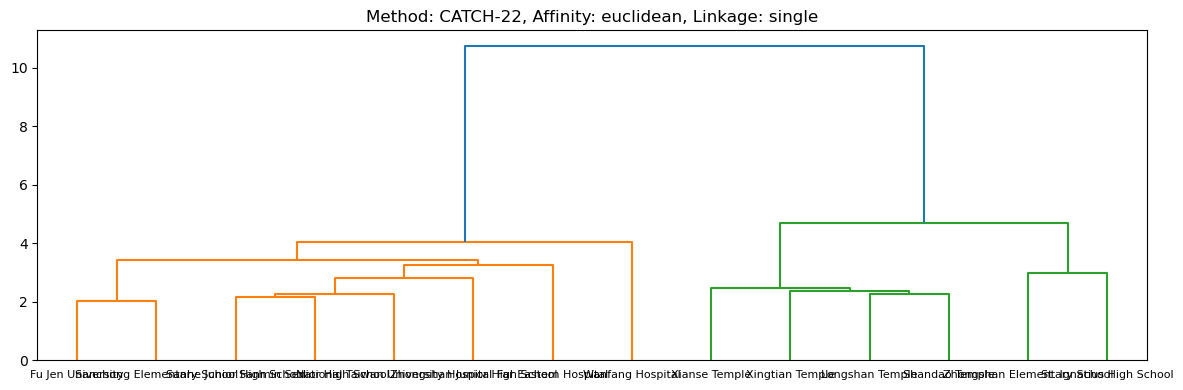

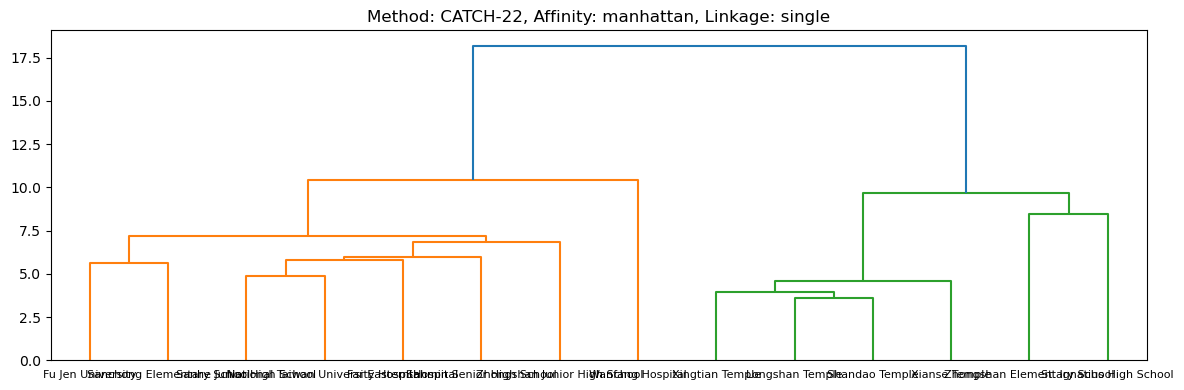

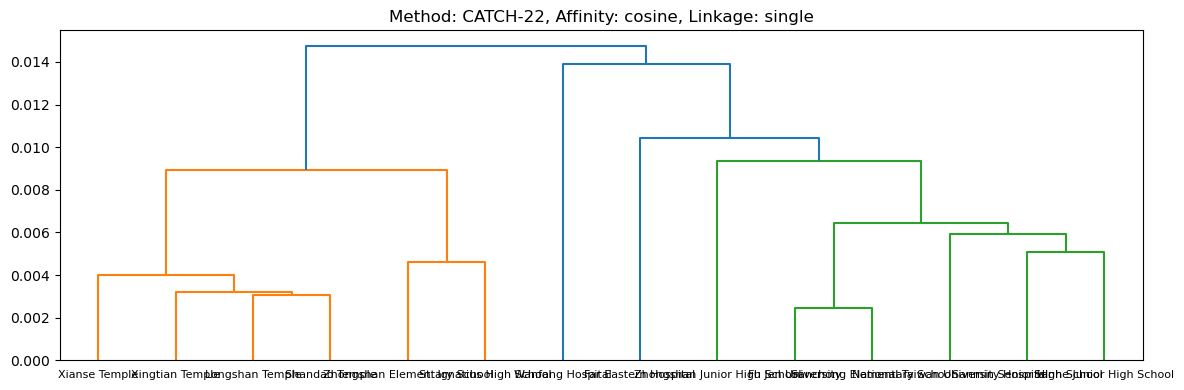

In [6]:
import catch22 # znorm internally

observationvectors = []
for c in columns_all:
    if " exit" in c:
        if c[:-5] in subsetstationnames:
            ts = np.asarray(zscore(allstationdata[c],nan_policy='omit'))
            bad = np.where(np.isnan(ts))
            ts[bad] = np.nanmean(ts)
            numts += 1
            fV = catch22.catch22_all(ts)
            fV_values = np.array(fV['values'])
            observationvectors.append(fV_values)

rootsavename = "<save figures to this directory>"
linkagetypes = ['ward','complete', 'average', 'single']
affinities = ['euclidean','manhattan', 'cosine'] #l2 is also accepted, but is redundant
for linkage in linkagetypes:
    for affinity in affinities:
        if linkage == 'ward':
            # plotty_ac(rootsavename+"euclidean{}.svg".format(linkage), "CATCH-22", "euclidean", linkage, observationvectors, subsetstationnames, label_colors)
            plotty_ac(None, "CATCH-22", "euclidean", linkage, observationvectors, subsetstationnames, label_colors)
            break
        else:
            # plotty_ac(rootsavename+"{}{}.svg".format(affinity,linkage), "CATCH-22",affinity,linkage,observationvectors,subsetstationnames,label_colors)
            plotty_ac(None, "CATCH-22", affinity, linkage, observationvectors, subsetstationnames, label_colors)
